# Intro to  Neural Networks with PyTorch
## Task 4 – Autoencoder on CIFAR-10 (reconstruction → SSL → latent space)

**Objective:** To train a simple convolutional Autoencoder (AE) to reconstruct images, then reuse its encoder for classification (SSL: Self-Supervised Learning), and inspect the latent space.

**Dataset + Split:** CIFAR-10 from torchvision (60,000 color images (32×32)). 50,000 images for training set with exactly 5000 per class, 10,000 for test set with exactly 1000 per class.

### Task 4A) Define Autoencoder

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, z_dim=128):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1) # Striding => Downsampling
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(in_features=64*8*8, out_features=z_dim)

    def forward(self, x): # x is tensor of shape (B, 3, 32, 32), where B –> batch size
        x = F.relu(self.conv1(x)) # (B, 32, 8, 8)
        x = F.relu(self.conv2(x)) # (B, 64, 8, 8)
        x = x.view(x.size(0), -1) # Reshape x to (B, 64*8*8); -1 => remaining dimension is automatically computed
        z = self.fc(x) # Latent space (B, z_dim)
        return z


class Decoder(nn.Module):
    def __init__(self, z_dim=128):
        super().__init__()
        self.fc = nn.Linear(in_features=z_dim, out_features=64*8*8) 
        self.conv1 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.fc(x) # (B, 64*8*8)
        x = x.view(x.size(0), 64, 8, 8) # (B, 64, 8, 8)
        x = F.interpolate(x, scale_factor=2, mode='nearest') # (B, 64, 16, 16)
        x = F.relu(self.conv1(x)) # (B, 32, 16, 16)
        x = F.interpolate(x, scale_factor=2, mode='nearest') # (B, 32, 32, 32)
        x = F.relu(self.conv2(x)) # (B, 3, 32, 32)
        return x


class Autoencoder(nn.Module):
    def __init__(self, z_dim=128):
        super().__init__()
        self.encoder = Encoder(z_dim=z_dim)
        self.decoder = Decoder(z_dim=z_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

In [5]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Evaluator function for reconstructed images
@torch.no_grad()
def evaluate_ae(loader, model, criterion, device):
    model.eval() # Evaluation mode => Dropout is disabled, BatchNorm uses stored statistics 
    total_loss = 0.0
    total_samples = 0

    for batch in loader:
        x = batch["image"].to(device)
        x_hat, _ = model(x) # Get reconstructed images
        loss = criterion(x_hat, x) # MSELoss

        total_loss += loss.item() * x.size(0) # x.size(0) => no. of samples in the batch
        total_samples += x.size(0)

    val_loss = total_loss / total_samples # Average loss per sample this epoch
    return val_loss

### Import and Preprocess Dataset

In [8]:
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# Find mean and standard deviation of dataset
dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=50000) # Entire training dataset
images, _ = next(iter(loader))
mean, std = images.mean([0, 2, 3]), images.std([0, 2, 3]) # Ignore channel dimension
print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.4914, 0.4822, 0.4465]), Std: tensor([0.2470, 0.2435, 0.2616])


In [9]:
# Function to get training policy according to selection
def get_train_transform(policy):
    """
    Define transform according to selected policy only for training set
    """
    if policy == "none":
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
    if policy == "light":
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop(size=32, padding=4),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(mean, std),
        ])


# Transform for validation and test sets
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


# Function to make train/val/test splits
def split_train_val_indices(seed=40, val_size=5000):
    rng = np.random.default_rng(seed=seed) # Random number generator object
    indices = np.arange(50000)
    rng.shuffle(indices)
    val_indices = indices[:val_size].tolist()
    train_indices = indices[val_size:].tolist()
    return train_indices, val_indices


# Class to apply dataset augmentation for training set according to selection
class CIFAR10DatasetClass(Dataset):
    def __init__(self, split, indices, policy):
        """
        split => "train" or "val" or "test"
        indices => train_indices or val_indices obtained from split_train_val_indices, or else None
        policy => "none" or "light"
        """
        assert split in ["train", "val", "test"]
        self.split = split
        self.indices = indices
        self.policy = policy
        train_flag = (split != "test")
        self.base_dataset = datasets.CIFAR10(root='./data', train=train_flag, download=True)
        self.class_names = self.base_dataset.classes
        self.train_transform = get_train_transform(policy)
        self.eval_transform = eval_transform

    def __len__(self):
        return len(self.indices) if self.indices is not None else len(self.base_dataset) # Get indices for train/val

    def __getitem__(self, i):
        idx = self.indices[i] if self.indices is not None else i
        image, label = self.base_dataset[idx]
        if self.split == "train":
            image = self.train_transform(image) # Apply augmentation for training data
        else:
            image = self.eval_transform(image) # Apply deterministic transform for val/test data
        return {"image": image, "label": int(label)} # Return dictionary of transformed images and labels        

In [10]:
def get_loaders(policy, seed=40, batch_size=128):
    train_indices, val_indices = split_train_val_indices(seed=seed, val_size=5000)

    # Create dataset class objects
    train_ds = CIFAR10DatasetClass(split="train", indices=train_indices, policy=policy)
    val_ds = CIFAR10DatasetClass(split="val", indices=val_indices, policy="none")
    test_ds = CIFAR10DatasetClass(split="test", indices=None, policy="none")

    # Define loaders
    train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, train_ds.class_names

### Training

In [12]:
# Function to denormalize images for preview
def denormalize(x, mean, std):
    """
    x is a tensor of shape (B, C, H, W) or (C, H, W)
    """
    if not torch.is_tensor(x):
        raise TypeError("x must be a torch.Tensor")

   # Convert mean and std to tensors on same device and reshape into (1, C, 1, 1)
    mean = mean.to(x.device).view(1, -1, 1, 1) # -1 => infer this dimension
    std = std.to(x.device).view(1, -1, 1, 1)

    # If single image (C, H, W), add batch dim
    was_single = (x.dim() == 3)
    if was_single:
        x = x.unsqueeze(0) # (1, C, H, W) for normalization

    x = x * std + mean # Denormalize
    x = x.clamp(0, 1)

    if was_single:
        x = x.squeeze(0) # Return to original dimension
    return x

In [13]:
# Function to display original and reconstructed images
import matplotlib.pyplot as plt

def show_reconstructions(x, x_hat, mean, std, n=8):
    """
    x and x_hat are images of dimensions (C, H, W)
    n is the number of images that are displayed from the beginning of a batch
    """
    x_dnorm = denormalize(x[:n].detach(), mean, std).cpu() # Denormalize first n images from batch
    xhat_dnorm = denormalize(x_hat[:n].detach(), mean, std).cpu() # Detach => remove from computation because we are not training

    fig, axes = plt.subplots(2, n, figsize=(2*n, 4)) # 2 rows, n columns
    for i in range(n):
        axes[0, i].imshow(x_dnorm[i].permute(1, 2, 0)) # Change dimensions because matplotlib expects (H, W, C)
        axes[0, i].axis("off")
        axes[1, i].imshow(xhat_dnorm[i].permute(1, 2, 0))
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original", fontsize=12)
    axes[1, 0].set_title("Reconstructed", fontsize=12)
    plt.tight_layout()
    plt.show()

In [14]:
import copy

def train_and_validate_ae(model, train_loader, val_loader, criterion, optimizer, device, max_epochs=10):
    best_state = None
    best_val_loss = float("inf")

    train_loss_hist = []
    val_loss_hist = []

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_loss = 0.0
        total_samples = 0

        # TRAINING
        for batch in train_loader:
            x = batch["image"].to(device)
            optimizer.zero_grad(set_to_none=True) # Reset gradients from previous step
            
            x_hat, _ = model(x) # Forward pass
            loss = criterion(x_hat, x)
            loss.backward() # Backpropagation
            optimizer.step() # Update weights using optimizer

            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

        train_loss = total_loss / total_samples

        # VALIDATION
        val_loss = evaluate_ae(val_loader, model, criterion, device)

        # For plotting
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)

        # Checkpoint if val loss reduces
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

        # To display validation reconstruction images every 5 epochs
        if epoch % 5 == 0:
            model.eval()
            batch = next(iter(val_loader))
            x = batch["image"].to(device)

            with torch.no_grad():
                x_hat, _ = model(x)
            show_reconstructions(x, x_hat, mean, std, n=8)

    if best_state is not None:
        model.load_state_dict(best_state)

    return train_loss, best_val_loss, train_loss_hist, val_loss_hist    


Policy: none

Epoch 01 | train_loss=0.5658 | val_loss=0.5285
Epoch 02 | train_loss=0.5087 | val_loss=0.5137
Epoch 03 | train_loss=0.4995 | val_loss=0.5092
Epoch 04 | train_loss=0.4973 | val_loss=0.5070
Epoch 05 | train_loss=0.4944 | val_loss=0.5060


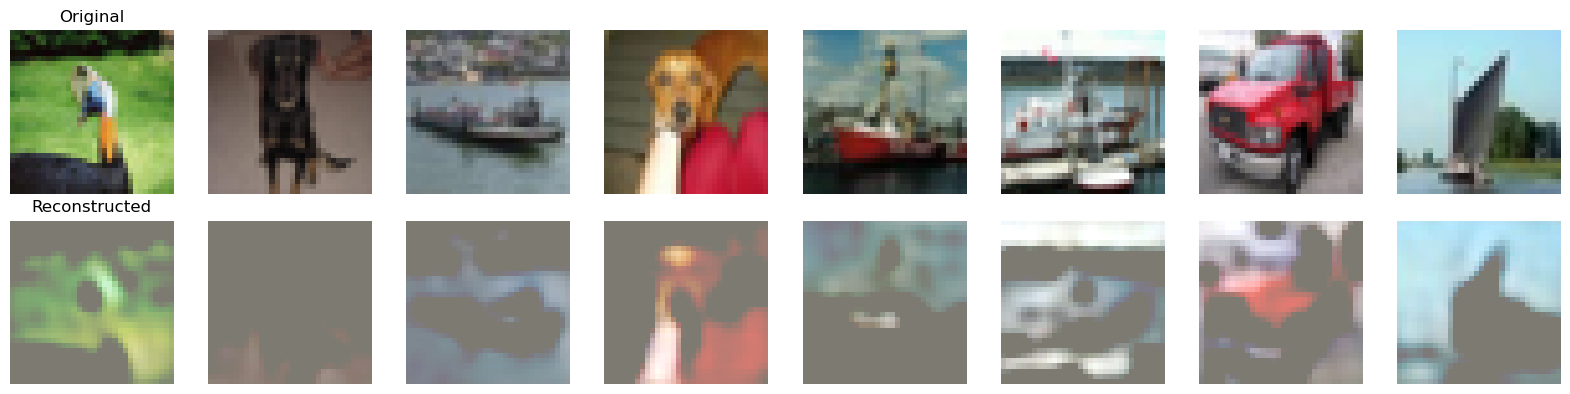

Epoch 06 | train_loss=0.4939 | val_loss=0.5068
Epoch 07 | train_loss=0.4929 | val_loss=0.5049
Epoch 08 | train_loss=0.4928 | val_loss=0.5045
Epoch 09 | train_loss=0.4920 | val_loss=0.5047
Epoch 10 | train_loss=0.4918 | val_loss=0.5041


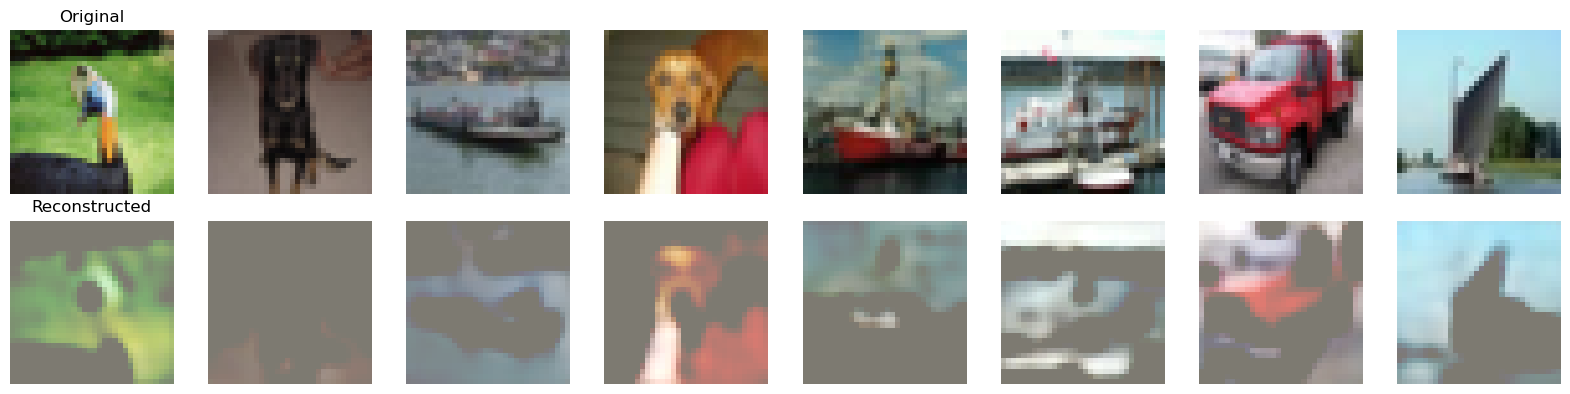


Test Recon Loss=0.4830 | Best Val Loss=0.5041

Policy: light

Epoch 01 | train_loss=0.9825 | val_loss=0.5317
Epoch 02 | train_loss=0.9282 | val_loss=0.5164
Epoch 03 | train_loss=0.9175 | val_loss=0.5114
Epoch 04 | train_loss=0.9144 | val_loss=0.5089
Epoch 05 | train_loss=0.9132 | val_loss=0.5084


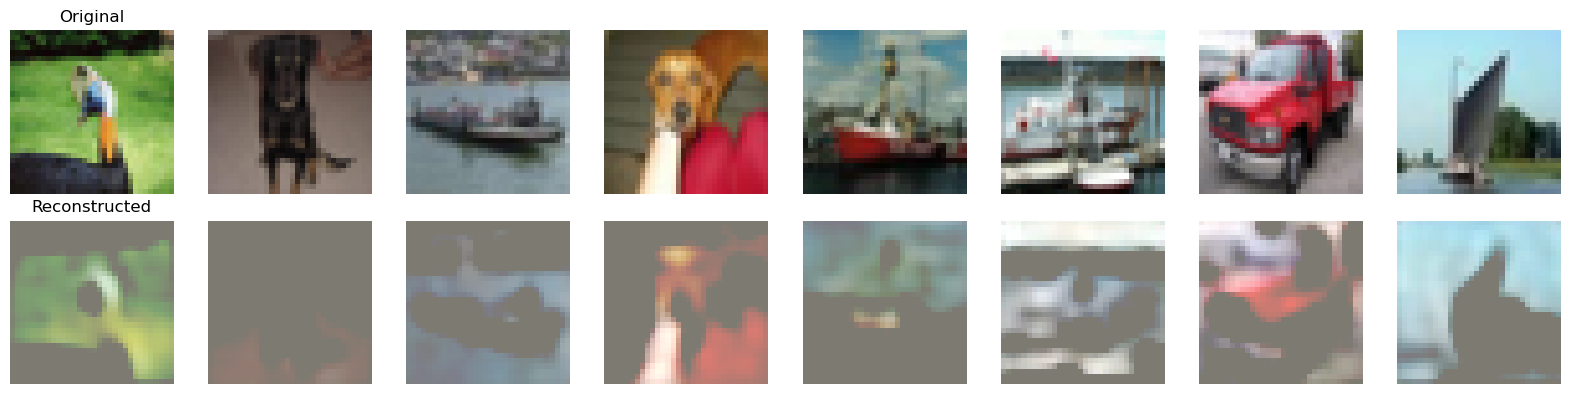

Epoch 06 | train_loss=0.9133 | val_loss=0.5064
Epoch 07 | train_loss=0.9126 | val_loss=0.5062
Epoch 08 | train_loss=0.9105 | val_loss=0.5058
Epoch 09 | train_loss=0.9114 | val_loss=0.5057
Epoch 10 | train_loss=0.9119 | val_loss=0.5052


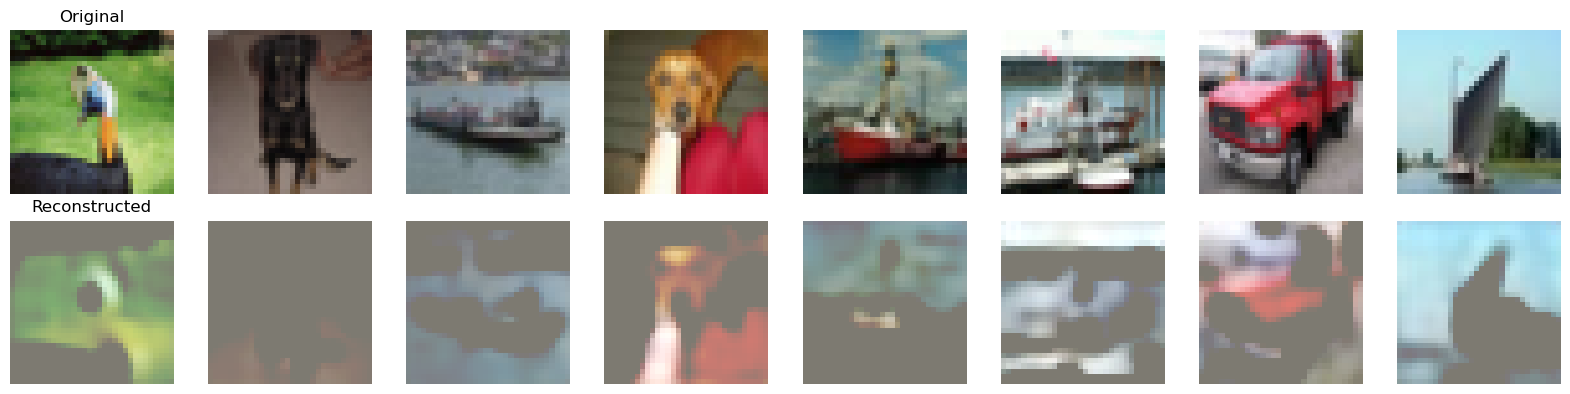


Test Recon Loss=0.4842 | Best Val Loss=0.5052


In [15]:
# Training, validation, testing for all policies 
policies = ["none", "light"]
results = []
recon_loss_curves = {}

for policy in policies:
    print("\n" + "="*60)
    print(f"Policy: {policy}")
    print("="*60 + "\n")

    train_loader, val_loader, test_loader, _ = get_loaders(policy, seed=40, batch_size=128)

    model = Autoencoder(z_dim=128).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # TRAIN AND VALIDATE
    last_train_loss, best_val_loss, train_loss_hist, val_loss_hist = train_and_validate_ae(
        model, train_loader, val_loader, criterion, optimizer, device, max_epochs=10
    )
    torch.save(model.state_dict(), f"ae_{policy}_best.pth")
    
    # TESTING
    test_loss = evaluate_ae(test_loader, model, criterion, device)

    results.append((policy, last_train_loss, best_val_loss, test_loss))
    recon_loss_curves[policy] = (train_loss_hist, val_loss_hist)

    print(f"\nTest Recon Loss={test_loss:.4f} | Best Val Loss={best_val_loss:.4f}")

### Task 4B) Linear Classifier

In [ ]:
@torch.no_grad()
def evaluate_classifier(loader, model, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch in loader:
        x = batch["image"].to(device)
        y = batch["label"].to(device)
        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_samples += x.size(0)

    avg_loss = total_loss / total_samples
    avs_acc = total_correct / total_samples
    
    return 